In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [125]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [108]:
zip_codes = crop_sim.load_zip("60601")
print(zip_codes)

     ZIP  latitude  longitude
0  60601   41.8858   -87.6181


In [109]:
# crop_sim.generate_near()

In [110]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [111]:
ecocrop_df = crop_sim.load_ecocrop()

In [112]:


# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)

# tmax = 35

In [113]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [114]:
print(zip_codes['loca_index'].values)

[(30, 22)]


In [115]:
lat, lon = zip_codes['loca_index'].values[0]

In [116]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [117]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, frost_tolerance)

In [118]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [119]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


30
36
174
20
26
164
10
16
154
0
6
144
134
124
114
104
94
84


In [120]:
view_window = 105
print(optimal_planting_ranges)

{85: [[Timestamp('2022-04-11 12:00:00'), Timestamp('2022-05-04 12:00:00')], [Timestamp('2022-08-14 12:00:00'), Timestamp('2022-09-12 12:00:00')], [Timestamp('2023-03-29 12:00:00'), Timestamp('2023-09-12 12:00:00')]], 95: [[Timestamp('2022-04-11 12:00:00'), Timestamp('2022-04-24 12:00:00')], [Timestamp('2022-08-14 12:00:00'), Timestamp('2022-09-02 12:00:00')], [Timestamp('2023-03-29 12:00:00'), Timestamp('2023-09-02 12:00:00')]], 105: [[Timestamp('2022-08-14 12:00:00'), Timestamp('2022-08-23 12:00:00')], [Timestamp('2023-03-29 12:00:00'), Timestamp('2023-08-23 12:00:00')]], 115: [[Timestamp('2023-03-29 12:00:00'), Timestamp('2023-08-13 12:00:00')]], 125: [[Timestamp('2023-03-29 12:00:00'), Timestamp('2023-08-03 12:00:00')]], 135: [[Timestamp('2023-03-29 12:00:00'), Timestamp('2023-07-24 12:00:00')]], 145: [[Timestamp('2023-03-29 12:00:00'), Timestamp('2023-07-14 12:00:00')]], 155: [[Timestamp('2023-03-29 12:00:00'), Timestamp('2023-07-04 12:00:00')]], 165: [[Timestamp('2023-03-29 12:00:

In [126]:
import matplotlib
matplotlib.pyplot.close()
optimal_planting_ranges[view_window]

[[Timestamp('2022-08-14 12:00:00'), Timestamp('2022-08-23 12:00:00')],
 [Timestamp('2023-03-29 12:00:00'), Timestamp('2023-08-23 12:00:00')]]

In [127]:
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[view_window]))

[((3, 29), (8, 23))]


(3, 29, 8, 23)

In [81]:
%matplotlib widget

In [82]:
import matplotlib

In [86]:
import ephem
import datetime

observer = ephem.Observer()
observer.lat = str(lat)
observer.lon = str(lon)
observer.pressure = 0  # Disable atmospheric refraction for more accurate sunrise/sunset
sun = ephem.Sun()

start_date = datetime.date(2022, 1, 1)  # Start of the year
end_date = datetime.date(2023, 12, 31)  # End of the year
dates = []
day_lengths = []

current_date = start_date
while current_date <= end_date:
    observer.date = current_date
    try:
        sunrise = observer.next_rising(sun, use_center=True)  # Use center of the sun for accuracy
        sunset = observer.next_setting(sun, use_center=True)

        # Convert sunrise and sunset to local timezone
        sunrise = ephem.localtime(sunrise)#.replace(tzinfo=timezone)
        sunset = ephem.localtime(sunset)#.replace(tzinfo=timezone)

        # Ensure sunset is after sunrise
        if sunset < sunrise:
            sunset += datetime.timedelta(days=1)

        day_length = sunset - sunrise
        dates.append(current_date)
        day_lengths.append(day_length.total_seconds() / 3600)  # Convert to hours
    except ephem.AlwaysUpError:
        # Handle polar days
        dates.append(current_date)
        day_lengths.append(24)
    except ephem.NeverUpError:
        # Handle polar nights
        dates.append(current_date)
        day_lengths.append(0)
    current_date += datetime.timedelta(days=1)
    # try:
        
    #     current_datetime = datetime.datetime.combine(current_date, datetime.time(3, 0))  
    #     sunrise = sun.get_sunrise_time(current_datetime)
    #     sunset = sun.get_sunset_time(current_datetime)
    #     day_length = sunset - sunrise
    #     print([day_length, sunset, sunrise])
    #     dates.append(current_date)
    #     day_lengths.append(day_length.total_seconds() / 3600)  # Convert to hours
    # except SunTimeException:
    #     # Handle days without sunrise/sunset (e.g., polar regions)
    #     dates.append(current_date)
    #     day_lengths.append(0)  # Or some appropriate value
    current_date += datetime.timedelta(days=1)


In [87]:
# print(day_lengths)

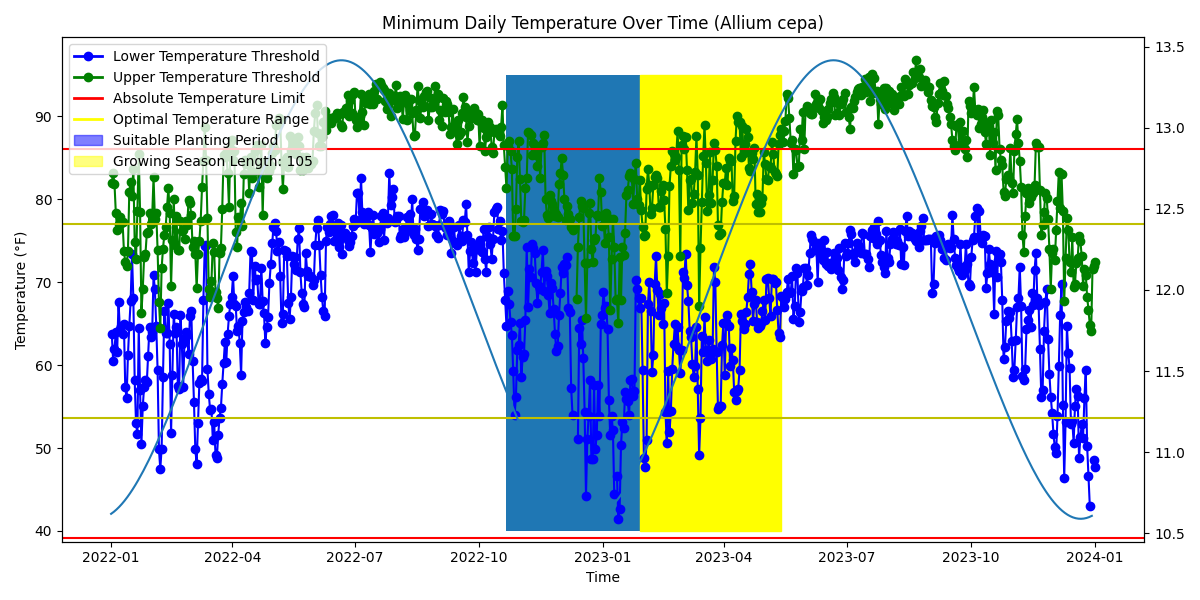

In [88]:
import crop_sim
import importlib
importlib.reload(crop_sim)
crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name, day_lengths, dates)


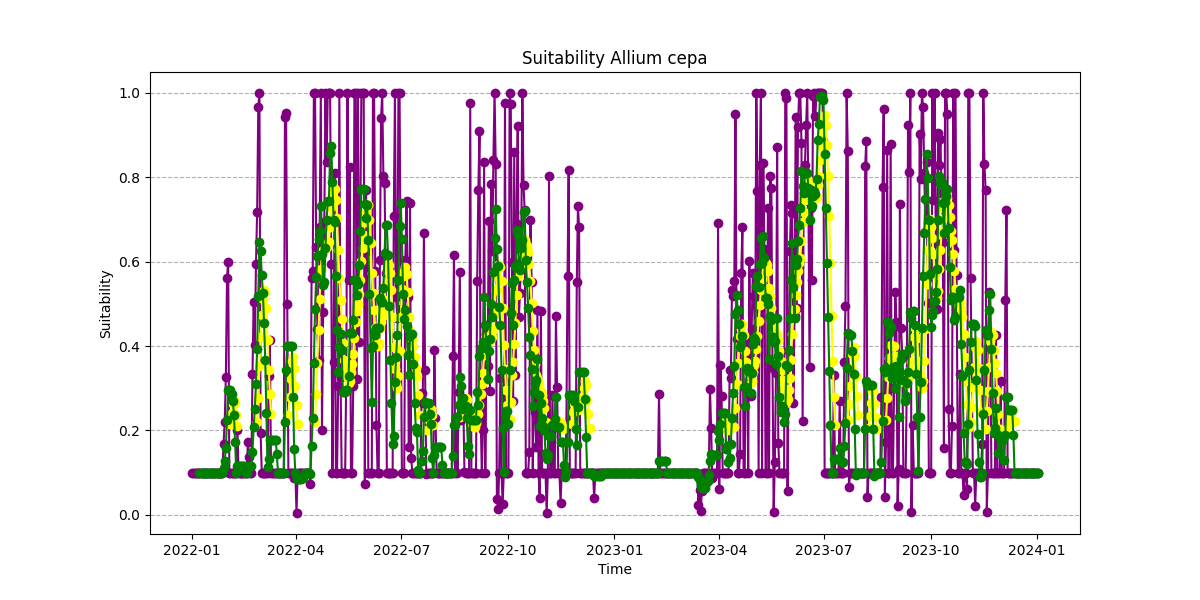

In [147]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)